# Customer Churn Prediction

This notebook analyzes customer churn for a telecommunications provider with the goal of identifying customers at risk of discontinuing service.

The objective is to build a predictive model that estimates churn probability using customer demographics, service subscriptions, and billing information.

Accurate churn prediction enables targeted retention strategies, helping businesses reduce customer attrition and associated revenue loss.

The analysis follows a structured workflow including exploratory data analysis, feature engineering, and supervised classification modeling.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import re

# Custom functions
from HelperFunctions import info_dtypes_hist
from HelperFunctions import style_ax,add_percent_labels
from HelperFunctions.validation_rules import validation_rules

# Data Loading & Initial Inspection


Number of Rows: 7043
Number of Columns: 21

[COLUMNS]
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='str')

[DataType Summary]



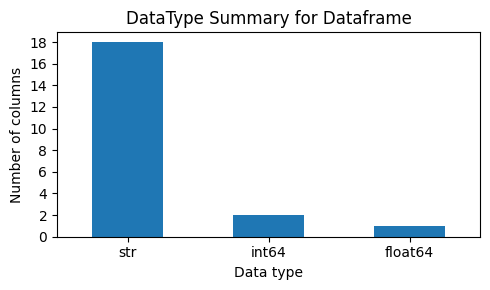

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df=pd.read_csv('Datasets/raw__WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"""
Number of Rows: {len(df)}
Number of Columns: {len(df.columns)}

[COLUMNS]
{df.columns}

[DataType Summary]
""")
info_dtypes_hist(df,"DataType Summary for Dataframe")

display(df.head())

The target variable, `Churn`, is binary and indicates whether a customer has discontinued service. This framing supports binary classification models focused on identifying customers at risk of attrition.

# Data Quality Assessment

## Null/Empty Value Checks

Note: Change in color shows the presence of null values.


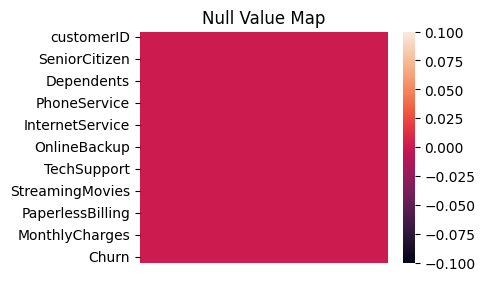

In [3]:
# Missing Value Checks
plt.figure(figsize=(4,3))
ax = sns.heatmap(df.isna().T)
ax.xaxis.set_visible(False)
plt.title("Null Value Map")
print("Note: Change in color shows the presence of null values.")
plt.show()

In [4]:
# Empty value checks
blank_string_mask=df.apply(
    lambda col:col.astype(str).str.strip().eq("")
)
print("Column with empty strings")
blank_string_mask.sum()[blank_string_mask.sum()>0]

Column with empty strings


TotalCharges    11
dtype: int64

In [5]:
# Convert the empty strings in nans
df["TotalCharges"] = df["TotalCharges"].replace(r'^\s*$', np.nan, regex=True)

# Converting "TotalCharges" into numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Deleting these 11 entires due to information loss
df.dropna(subset=["TotalCharges"], inplace=True)

## DataType Checks

In [6]:
dtypes_df = pd.DataFrame({"dtype": df.dtypes.astype(str)})
dtypes_df = dtypes_df.sort_values(by="dtype")  # optional: sort by dtype

# Configuration
batch_size = 4   # number of columns per line
# Get column names
cols = list(dtypes_df.index)

# Print aligned batches
print("COLUMN DATATYPE SUMMARY:\n")

for i in range(0, len(cols), batch_size):
    batch = cols[i:i+batch_size]
    line = []
    for col in batch:
        dtype_val = str(dtypes_df.loc[col, "dtype"])
        # Align column name and dtype
        line.append(f"{col:<{25}}: {dtype_val:<{10}}")
    print("   ".join(line))

COLUMN DATATYPE SUMMARY:

MonthlyCharges           : float64      TotalCharges             : float64      SeniorCitizen            : int64        tenure                   : int64     
customerID               : str          PaymentMethod            : str          PaperlessBilling         : str          Contract                 : str       
StreamingMovies          : str          StreamingTV              : str          TechSupport              : str          OnlineBackup             : str       
OnlineSecurity           : str          InternetService          : str          MultipleLines            : str          PhoneService             : str       
Dependents               : str          Partner                  : str          gender                   : str          DeviceProtection         : str       
Churn                    : str       


## Invalid value checks

In [7]:
GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

print("DATA VALUE CHECK SUMMARY:")
batch_size = 4
cols = list(validation_rules.keys())
col_width = 25  # adjust width for alignment

for i in range(0, len(cols), batch_size):
    batch = cols[i:i+batch_size]
    line = []
    for col in batch:
        status = f"{GREEN}Valid!{RESET}" if validation_rules[col](df[col]) else f"{RED}Invalid!{RESET}"
        # Align column name and status in fixed width
        line.append(f'{col:<20}: {status:<10}')
    print("   ".join(line))

DATA VALUE CHECK SUMMARY:
SeniorCitizen       : Valid!   tenure              : Valid!   MonthlyCharges      : Valid!   TotalCharges        : Valid!
PaperlessBilling    : Valid!   StreamingMovies     : Valid!   StreamingTV         : Valid!   TechSupport         : Valid!
OnlineBackup        : Valid!   OnlineSecurity      : Valid!   InternetService     : Valid!   MultipleLines       : Valid!
PhoneService        : Valid!   Dependents          : Valid!   Partner             : Valid!   gender              : Valid!
DeviceProtection    : Valid!   Churn               : Valid!


# Exploratory Data Analysis (EDA)

## Target Variable Analysis ("Churn")

In [8]:
td=df["Churn"]
churn_dist=pd.DataFrame({
    "Count": td.value_counts(),
    "Percentage (%)": (td.value_counts(normalize=True)*100).round(2)
})

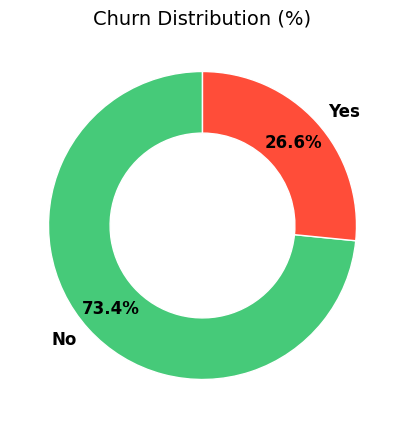

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.pie(
    churn_dist['Percentage (%)'],
    labels=churn_dist.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,
    colors=["#46ca79ff", "#ff4d39"],
    textprops=dict(size=12, weight='bold', color='black'),
    wedgeprops=dict(width=0.4, edgecolor='w')
)

ax.set_title("Churn Distribution (%)", fontsize=14)
plt.show()


### Key Observations

- The target variable exhibits class imbalance, with fewer churned customers than retained customers.
- This imbalance implies that accuracy alone is not a sufficient evaluation metric.
- Recall on churned customers is particularly important, as failing to identify churners leads to lost revenue opportunities.


### Observations
Approximately 26.6% of customers have churned, while 73.4% have been retained, indicating a moderately imbalanced target variable.

#### Business Interpretation
- 1 in 4 customers are leaving the service.
- Addressing this would prevent any revenue leakage.
- Addressing this would also increase revenue due to the positive impact increasing customer acquisition.

#### Technical Interpretation
- The dataset is not balanced; due to the major difference in churn rates.
    - Indicating that we would have to stratify when modelling.
- For the current dataset, a naive model predicting "No churn" for everyone would have 73.4% accuracy.
- Therefore accuracy alone would be misleading. Would have to investigate on identifying churners correctly.

## Customer Demographics vs Churn

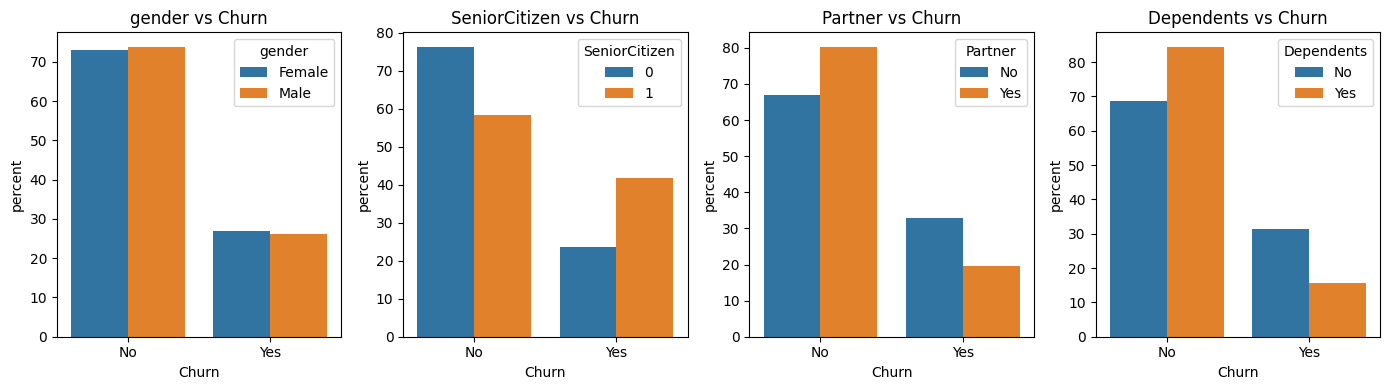

In [10]:
customer_dependent_features=['gender', 'SeniorCitizen', 'Partner', 'Dependents']

fig,axes=plt.subplots(1,4,figsize=(14,4))
axes=axes.flatten()

for selected_feature, ax in zip(customer_dependent_features,axes):
    td=(df.groupby([selected_feature,"Churn"])
        .size()
        .groupby(level=0,group_keys=False)
        .apply(lambda x: (100*x)/x.sum())
        .reset_index(name="percent")
        )
    sns.barplot(x='Churn',y='percent',hue=selected_feature,data=td,ax=ax)
    ax.set_title(f"{selected_feature} vs Churn")
    ax.legend(title=selected_feature)
    del td
plt.tight_layout()
plt.show()

### Observations

| Feature        | Key Insight | Churn Behavior |
|----------------|------------|----------------|
| **Gender**     | Not a key factor; churn similar for both genders. | Nearly identical churn rates across genders. |
| **SeniorCitizen** | Seniors are more likely to leave; targeted retention strategies recommended. | Churn rate: Seniors 41.7%, Non-seniors 23.7% (≈1.8× higher). |
| **Partner**    | Customers with partners are more stable; focus retention on singles. | Churn: With partner 19.7%, Without partner 33% (≈1.7× higher). |
| **Dependents** | Customers with dependents are more loyal; focus retention on those without. | Churn: With dependents 15.5%, Without 31.3%. Strong positive correlation with retention. |


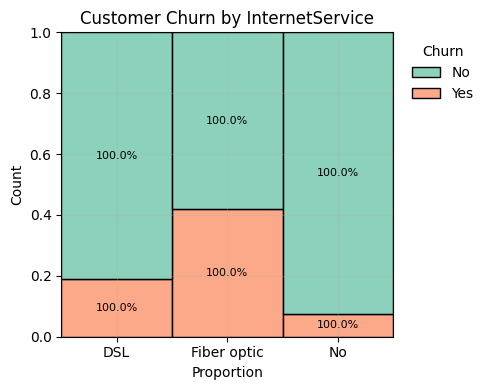

In [11]:
# Identified potential model feature InternetServices
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for i, col in enumerate(['InternetService']):
    sns.histplot(
        df,
        x=col,
        hue='Churn',
        multiple='fill',
        ax=ax,
        palette="Set2"
    )
    add_percent_labels(ax)
    style_ax(ax, f"Customer Churn by {col}", xlabel="Proportion")
    sns.move_legend(
        ax,
        "upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=False
    )

plt.tight_layout()
plt.show()

### Conclusion
- "SeniorCitizen", "Partner" and "Dependents" could be useful for model accuracy when combined with other relevan features.
- "InternetService" shows a clear distinction where those with fibreoptic use shows higher churn potential.

## Account & Subscription Analysis

### Tenure

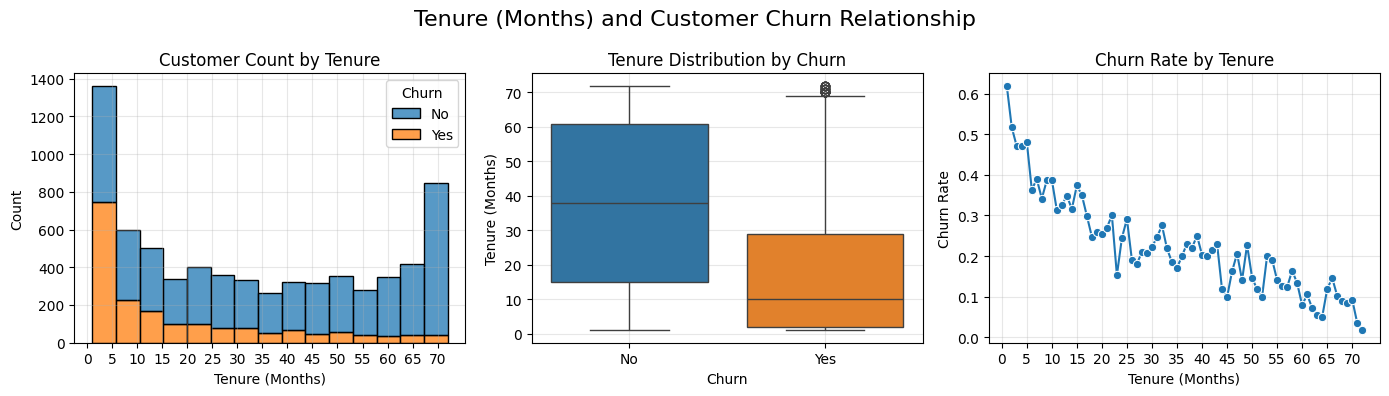

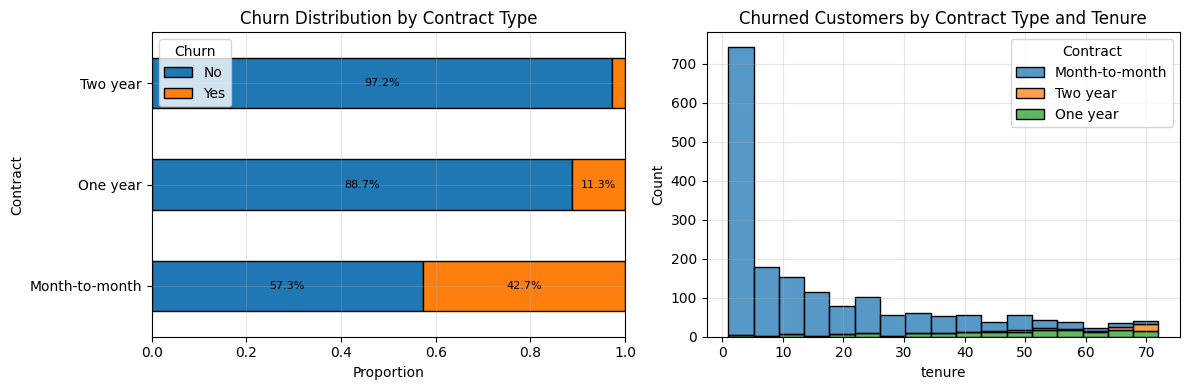

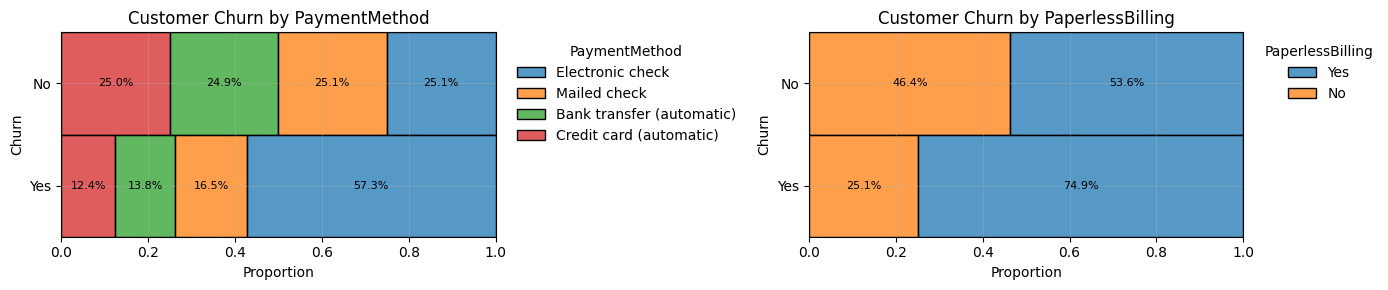

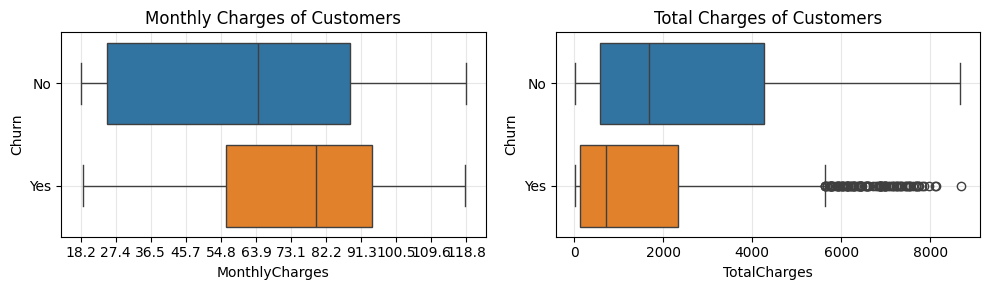

In [12]:
# TENURE
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.histplot(df, x='tenure', hue='Churn', multiple='stack',
             edgecolor='black', ax=ax[0])
style_ax(
    ax[0],
    "Customer Count by Tenure",
    xlabel="Tenure (Months)",
    ylabel="Count",
    xticks=range(0, int(df.tenure.max()) + 1, 5)
)

sns.boxplot(df, x='Churn', y='tenure', hue='Churn', ax=ax[1])
style_ax(
    ax[1],
    "Tenure Distribution by Churn",
    ylabel="Tenure (Months)"
)

tenure_rate = df.groupby('tenure')['Churn'].apply(lambda x: (x == 'Yes').mean())
sns.lineplot(x=tenure_rate.index, y=tenure_rate, marker='o', ax=ax[2])
style_ax(
    ax[2],
    "Churn Rate by Tenure",
    xlabel="Tenure (Months)",
    ylabel="Churn Rate",
    xticks=range(0, int(df.tenure.max()) + 1, 5)
)

fig.suptitle("Tenure (Months) and Customer Churn Relationship", fontsize=16)
plt.tight_layout()
plt.show()

# CONTRACT
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

contract_pct = (
    df.groupby(['Contract', 'Churn'])
      .size()
      .groupby(level=0)
      .apply(lambda x: 100 * x / x.sum())
      .unstack()
)
contract_pct.index = contract_pct.index.get_level_values(0)
contract_prop = contract_pct / 100
contract_prop.plot(
    kind='barh',
    stacked=True,
    edgecolor='black',
    ax=ax[0]
)
style_ax(ax[0], "Churn Distribution by Contract Type", xlabel="Proportion")
ax[0].set_xlim(0, 1)

add_percent_labels(ax[0])

churned = df[df['Churn'] == 'Yes']
sns.histplot(
    churned,
    x='tenure',
    hue='Contract',
    multiple='stack',
    edgecolor='black',
    ax=ax[1]
)
style_ax(ax[1], "Churned Customers by Contract Type and Tenure")

plt.tight_layout()
plt.show()

# PAYMENT METHOD & PAPERLESS BILLING
fig, ax = plt.subplots(1, 2, figsize=(14, 3))

for i, col in enumerate(['PaymentMethod', 'PaperlessBilling']):
    sns.histplot(
        df,
        y='Churn',
        hue=col,
        multiple='fill',
        ax=ax[i]
    )
    add_percent_labels(ax[i])
    style_ax(ax[i], f"Customer Churn by {col}", xlabel="Proportion")
    sns.move_legend(
        ax[i],
        "upper left",
        bbox_to_anchor=(1.02, 1),
        frameon=False
    )

plt.tight_layout()
plt.show()

# MONTHLY & TOTAL CHARGES
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.boxplot(df, x='MonthlyCharges', y='Churn', hue='Churn', ax=ax[0])
style_ax(ax[0], "Monthly Charges of Customers")
ax[0].set_xticks(
    np.linspace(df.MonthlyCharges.min(), df.MonthlyCharges.max(), 12)
)

sns.boxplot(df, x='TotalCharges', y='Churn', hue='Churn', ax=ax[1])
style_ax(ax[1], "Total Charges of Customers")

plt.tight_layout()
plt.show()


<table>
  <tr>
    <th>Feature</th>
    <th>Business Insight</th>
    <th>Technical Insight</th>
    <th>Data Evidence</th>
  </tr>

  <tr>
    <td>Tenure</td>
    <td>
      High churn risk among new customers; long-term customers rarely churn. 
      Early engagement and onboarding are critical for retention.
    </td>
    <td>
      Strong predictive feature with a negative relationship to churn; non-linear effects captured well by tree-based models.
    </td>
    <td>
      Churn is concentrated in the first 0–10 months and declines steadily with tenure; customers beyond 60 months are predominantly retained.
    </td>
  </tr>

  <tr>
    <td>Contract Type</td>
    <td>
      Month-to-month customers are the highest-risk segment. Longer contracts improve stability and revenue predictability.
    </td>
    <td>
      One of the strongest categorical predictors of churn, with potential interactions with other subscription features.
    </td>
    <td>
      Churn is highest for month-to-month contracts and decreases significantly for one- and two-year contracts.
    </td>
  </tr>

  <tr>
    <td>Tenure × Contract</td>
    <td>
      Post-contract churn suggests customers remain due to obligation rather than loyalty, indicating a need for loyalty programs.
    </td>
    <td>
      Interaction effects reinforce the individual predictive strength of tenure and contract length.
    </td>
    <td>
      Churn spikes shortly after one- and two-year contract completion, particularly around 50–60 months.
    </td>
  </tr>

  <tr>
    <td>Payment Method</td>
    <td>
      Electronic check users represent a high-risk churn segment; auto-pay methods are associated with stronger retention.
    </td>
    <td>
      Highly predictive categorical feature with strong class separation, especially for electronic check payments.
    </td>
    <td>
      Over half of churned customers use electronic checks, while non-churned customers are evenly distributed across payment methods.
    </td>
  </tr>

  <tr>
    <td>Paperless Billing</td>
    <td>
      Higher churn among paperless users suggests convenience alone does not ensure retention.
    </td>
    <td>
      Feature shows predictive potential but is affected by class imbalance, which may bias model learning.
    </td>
    <td>
      Approximately 75% of churned customers use paperless billing, compared to a near-even split among retained customers.
    </td>
  </tr>

  <tr>
    <td>Monthly Charges</td>
    <td>
      Higher-paying customers are more likely to churn, indicating price sensitivity or unmet value expectations.
    </td>
    <td>
      Distributions are clearly separable, making this a useful numeric feature for churn prediction.
    </td>
    <td>
      Median monthly charges are higher for churned customers (≈79.7) than non-churned customers (≈64.4).
    </td>
  </tr>

  <tr>
    <td>Total Charges</td>
    <td>
      Early-stage customers with low total spend churn frequently, while high-spend churners represent high-value loss.
    </td>
    <td>
      Strong predictive feature with non-linear behavior; tree-based models or log transformations are appropriate.
    </td>
    <td>
      Non-churned customers have a median total charge ~2.4× higher than churned customers, with notable high-value churn outliers.
    </td>
  </tr>
</table>


# Feature Engineering

Categorical features are encoded to enable their use in machine learning models. This transformation allows service-related and contract-based attributes to be incorporated into predictive models.


In [13]:
# Dropped customer id column as it provides no value to model
df.drop(['customerID','PhoneService','MultipleLines','OnlineBackup','DeviceProtection','StreamingTV','StreamingMovies'],axis=1,inplace=True)

# One hot encode the required features with boolean like attributes
df['Churn']=df['Churn'].map({"No":0,"Yes":1})

# Change format to categorical type
df['SeniorCitizen']=df['SeniorCitizen'].astype('category')
df['gender']=df['gender'].astype('category')
df['Partner']=df['Partner'].map({"Yes":1,"No":0}).astype('category')
df['Dependents']=df['Dependents'].map({"Yes":1,"No":0}).astype('category')


bins = [-1, 6, 18, 42, 60, float('inf')]
labels = ['Newbie', 'Starter', 'Growing', 'Established', 'Loyal']
df['tenure']=pd.cut(df['tenure'],bins=bins,labels=labels)

df['InternetService']=df['InternetService'].map({"DSL":0,"No":0,"Fiber optic":1}) # need to show why taken
df['InternetService']=df['InternetService'].astype('category')
df.rename(columns={"InternetService":"FiberOpticService"},inplace=True)

df['OnlineSecurity']=df['OnlineSecurity'].map({"Yes":1,"No internet service":1,"No":0}) # need to show why taken
df['OnlineSecurity']=df['OnlineSecurity'].astype('category')

df['TechSupport']=df['TechSupport'].map({"Yes":1,"No internet service":1,"No":0}) # need to show why taken
df['TechSupport']=df['TechSupport'].astype('category')

df['Contract']=df['Contract'].astype('category')
df['PaperlessBilling']=df['PaperlessBilling'].astype('category')
df['PaymentMethod']=df['PaymentMethod'].apply(lambda x: re.sub(r"[ ()]", "_", x)).astype('category')
df['MonthlyCharges']=pd.cut(df['MonthlyCharges'],bins=[-1,70,float('inf')],labels=['Low','High'])
df['TotalCharges']=df['TotalCharges'].astype('float32')


relevant_features=['Churn','gender','SeniorCitizen','Partner','Dependents','tenure','FiberOpticService','OnlineSecurity','TechSupport',
 'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges']
rowsize=7
print('FEATURES SELECTED FOR MODELLING')
for i in range(0,len(relevant_features),rowsize):
    print(', '.join(relevant_features[i:i+rowsize]))

# Ignored: [PhoneService,MultipleLines,OnlineBackup,DeviceProtection,StreamingTV,StreamingMovies]


FEATURES SELECTED FOR MODELLING
Churn, gender, SeniorCitizen, Partner, Dependents, tenure, FiberOpticService
OnlineSecurity, TechSupport, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges


### Prep data for predictive modelling

In [14]:
X=df.drop(['Churn'],axis=1)
y=df['Churn']

print('X(input) and y(output) created successfully!')

X(input) and y(output) created successfully!


# Predictive Modelling

### Modeling Objective

The goal of the model is to predict the probability of customer churn. From a business perspective, false negatives are more costly than false positives, as failing to identify at-risk customers results in missed retention opportunities.

Therefore, "accuracy" is not a good metric to use here as the data set is unbalanced where only 25% of the data are churned users. For our case, we want to focus on reducing false negatives as they are our key targets. Hence "recall" is the fitting metric to gauge the quality of the model.

Due to the lack of linear behaviour, we would be skipping and moving on to the tree based models.

## Catboost Model

0:	learn: 0.4401338	test: 0.4224599	best: 0.4224599 (0)	total: 208ms	remaining: 3m 27s
200:	learn: 0.5217391	test: 0.5080214	best: 0.5160428 (196)	total: 12.9s	remaining: 51.1s
400:	learn: 0.5471572	test: 0.5320856	best: 0.5320856 (378)	total: 34s	remaining: 50.9s
600:	learn: 0.5612040	test: 0.5347594	best: 0.5347594 (434)	total: 59.1s	remaining: 39.2s
800:	learn: 0.5725753	test: 0.5427807	best: 0.5427807 (696)	total: 1m 25s	remaining: 21.3s
999:	learn: 0.5812709	test: 0.5294118	best: 0.5427807 (696)	total: 1m 50s	remaining: 0us
bestTest = 0.5427807487
bestIteration = 696
Shrink model to first 697 iterations.
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1033
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



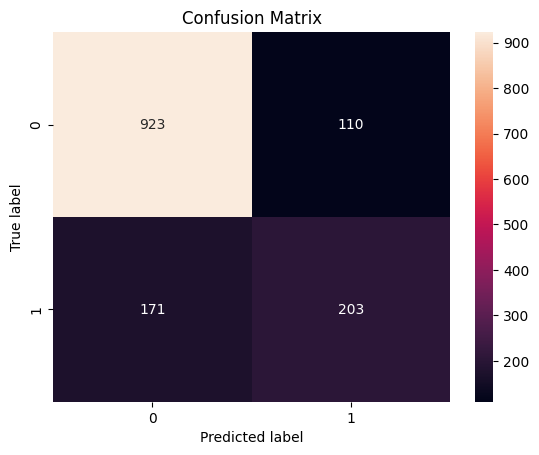

In [15]:
from HelperFunctions import CatBoostModel

catboost_model=CatBoostModel(X,y)

## LightBGM Model

Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.447285
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.44726


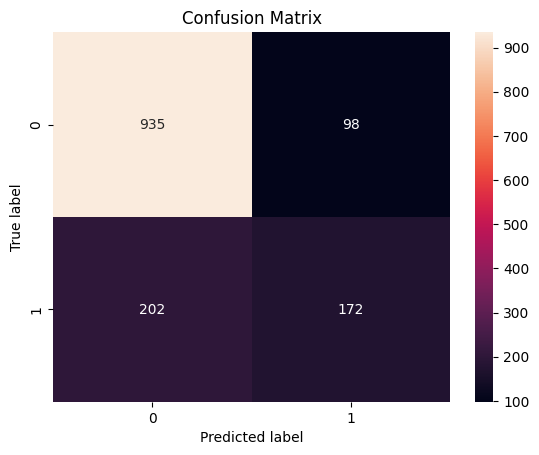

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.46      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.77      1407



In [16]:
from HelperFunctions import LightGbmModel

gbm_model=LightGbmModel(X,y)

## Random Forest

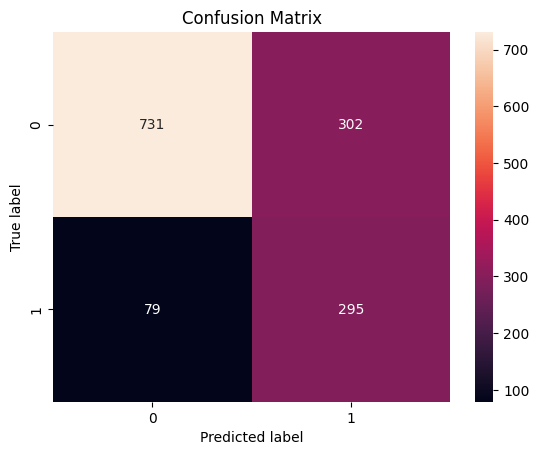

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [17]:
from HelperFunctions import RandomForestClassifierModel

rf_model=RandomForestClassifierModel(X,y)

From the 3 models used random forest was the best fit as it had the highest recall of 73%.

# Model Interpretation

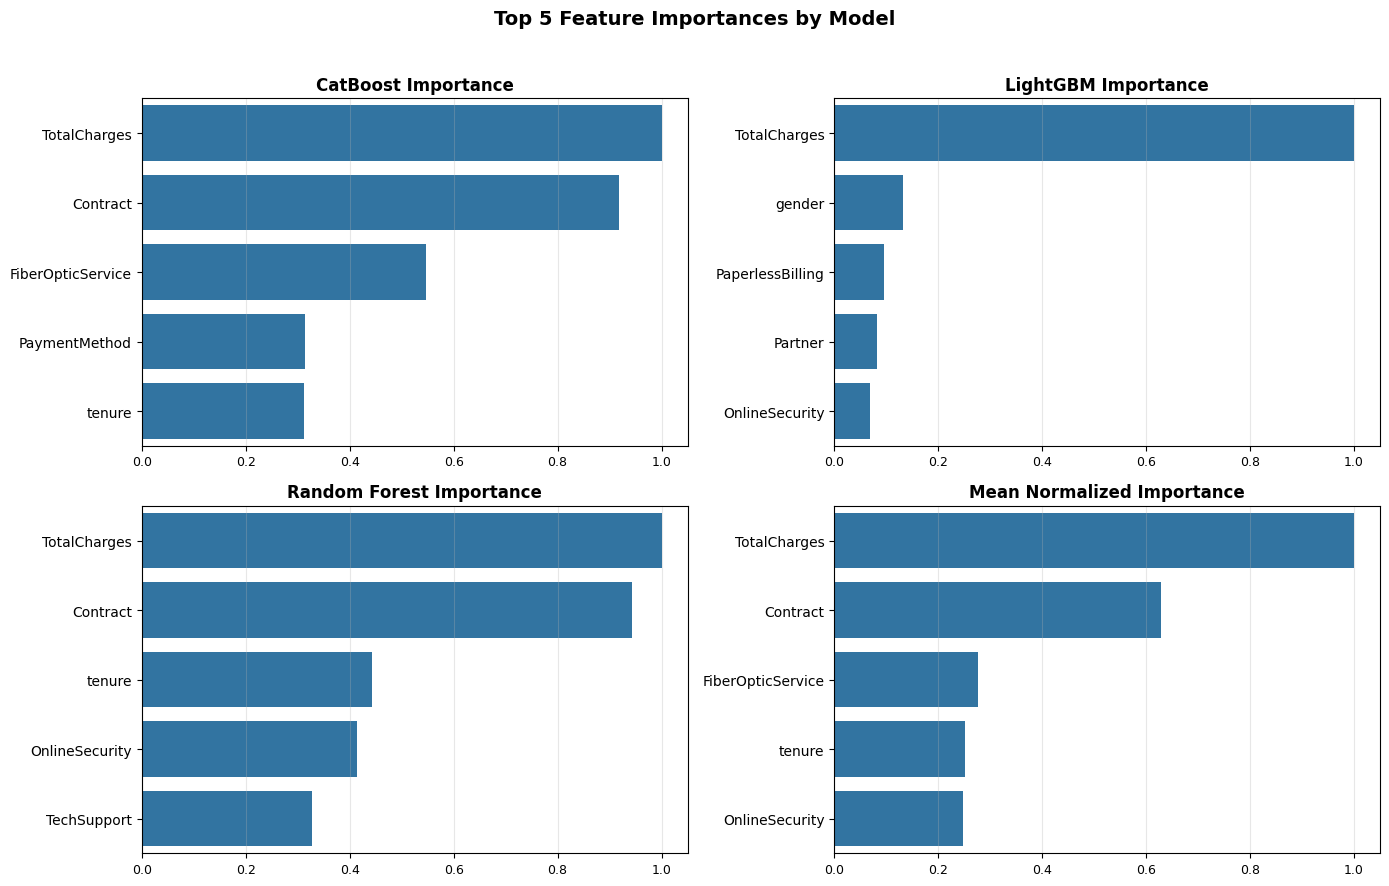

In [18]:
from HelperFunctions import PlotFeatureImportance

fi_df=PlotFeatureImportance(X,catboost_model,gbm_model,rf_model)

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

cat_features = X.select_dtypes(include=['category']).columns.tolist()

X_encoded = X.copy()
for col in cat_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

xtrain, xtest, ytrain, ytest = train_test_split(
    X_encoded, y, test_size=0.2, random_state=0, stratify=y
)


r = permutation_importance(rf_model, xtest, ytest, n_repeats=10)

importance_df = pd.DataFrame({
    "feature": xtest.columns,
    "importance": r.importances_mean,
    "std": r.importances_std
}).sort_values(by="importance", ascending=False)

print(importance_df.head())

              feature  importance       std
8            Contract    0.057996  0.007590
12       TotalCharges    0.045203  0.005723
5   FiberOpticService    0.036603  0.006099
6      OnlineSecurity    0.033120  0.004895
7         TechSupport    0.030490  0.003310


# Model Interpretations and Business Recommendations

| Question | Answer |
|----------|--------|
| **How well does the model perform?** | The Random Forest model achieved an accuracy of 73%, showing it can reliably predict customer churn. It correctly identifies most customers who will churn (recall = 0.79), which is important because missing a churner is more costly than contacting a customer who might stay. |
| **Why is recall more important than precision here?** | The business prefers to identify as many potential churners as possible, even if some are false alarms, so retention teams can act before it’s too late. |
| **What is permutation importance?** | It measures how much the model's performance drops when feature values are randomly shuffled, helping us identify which features are most important. |
| **Which features influence churn the most?** | Top drivers of churn identified by Random Forest are:<br>- **Contract**: Month-to-month customers churn more than long-term ones.<br>- **TotalCharges**: Newer customers are at highest risk.<br>- **FiberOpticService**: Higher churn among fiber users.<br>- **OnlineSecurity**: Customers without security add-ons churn more.<br>- **TechSupport**: Lack of support increases churn risk. |
| **What do these features tell us about customer behaviour?** | Churn is highest among newer customers, those without service add-ons, and customers with flexible contracts. This shows early experience and service quality strongly affect retention. |
| **What can the business do to reduce churn?** | Based on insights:<br>- Offer incentives to move customers to long-term contracts.<br>- Focus onboarding and support during the first 3–6 months.<br>- Investigate why FiberOptic users churn and develop strategies to counter it.<br>- Bundle OnlineSecurity and TechSupport with core plans.<br>- Proactively contact high-risk customers identified by the model. |
| **How can this model be used in practice?** | By scoring customers weekly on churn risk, the model helps customer success teams focus on at-risk accounts while enabling marketing teams to run precise retention campaigns. |


# Conclusions and Next Steps

**Conclusions**
- Customer tenure and contract type are strong indicators of churn behavior.
- The trained model demonstrates practical utility for identifying at-risk customers.

**Limitations**
- The analysis is limited to the available features and does not include customer interaction or usage intensity data.

**Next Steps**
- Incorporate additional behavioral features to improve performance.
- Tune classification thresholds based on retention campaign costs.
- Deploy the model as part of a customer retention decision pipeline.


# Final Executive Summary

| Section | Details |
|---------|---------|
| **Problem** | Customer churn reduces revenue and growth. Identifying at-risk customers early allows proactive retention strategies to keep them. |
| **Model Performance** | The Random Forest model achieved **73% accuracy** and **79% recall** for churners, meaning it can reliably identify most customers likely to leave. |
| **Key Churn Drivers** | - **Contract**: Month-to-month customers are at highest risk.<br>- **TotalCharges**: Newer customers with lower total spend churn more.<br>- **FiberOpticService**: Higher churn among fiber users.<br>- **OnlineSecurity & TechSupport**: Lack of these add-ons increases churn. |
| **Business Actions** | - Incentivize long-term contracts.<br>- Focus retention efforts on new customers (first 3–6 months).<br>- Investigate the FiberOptic Service for problem vectors.<br>- Bundle OnlineSecurity and TechSupport to increase stickiness.<br>- Use the model to flag high-risk customers weekly for proactive outreach. |
